## Notebook of Image Captionning 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk 
from nltk.corpus import stopwords
import cv2

%matplotlib inline

### Reading Text image Captions

In [4]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

captions = readTextFile("archive/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

name,caption  = captions[300].split('\t')
print("Image Name ", name, "\nCaption: " ,caption)

Image Name  1077931201_1e0bb83105.jpg#0 
Caption:  A man in a wetsuit is throwing a baby wearing a wetsuit up into the air .


### Mapping in a Dictionnary a list of Captions to each corresponding image 

Caption 1 ->  A man in a wetsuit is throwing a baby wearing a wetsuit up into the air .
Caption 2 ->  A man in a wetsuit is throwing a toddler up in the air and is ready to catch him .
Caption 3 ->  A man in water throwing a little boy up in the air and waiting for him to come down so he can catch him .
Caption 4 ->  The man is in the pool and throwing a small boy into the air .
Caption 5 ->  While water droplets fly , a man throws a little boy up in the air .


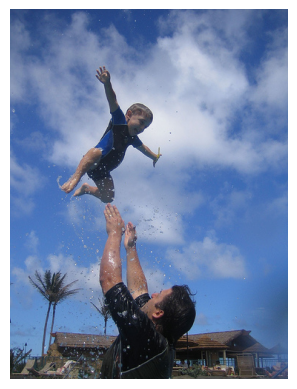

In [5]:
mapping_img_caption = {}

for caption in captions:
    name,caption = caption.split('\t')
    image_name = name.split(".")[0]
    # if the image id is already present or not
    if mapping_img_caption.get(image_name) is None:
        mapping_img_caption[image_name] = []
    mapping_img_caption[image_name].append(caption)
    
print("Caption 1 -> " ,mapping_img_caption["1077931201_1e0bb83105"][0])
print("Caption 2 -> " ,mapping_img_caption["1077931201_1e0bb83105"][1])
print("Caption 3 -> " ,mapping_img_caption["1077931201_1e0bb83105"][2])
print("Caption 4 -> " ,mapping_img_caption["1077931201_1e0bb83105"][3])
print("Caption 5 -> " ,mapping_img_caption["1077931201_1e0bb83105"][4])


img_path = "archive/Flickr8k_Dataset/Flicker8k_Dataset/"
img = cv2.imread(img_path + "1077931201_1e0bb83105.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning

In [6]:
def text_cleaning(caption):
    caption = caption.lower()
    caption = re.sub("[^a-z]", " ", caption)
    caption = caption.split()
    caption = [s for s in caption if len(s)>1]
    caption = " ".join(caption)
    return caption

print("Original Text -> A man in a wetsuit is throwing a baby wearing a wetsuit up into the air .")
print("Clean Text -> ", text_cleaning("A man in a wetsuit is throwing a baby wearing a wetsuit up into the air ."))

for key,caption_list in mapping_img_caption.items():
    for i in range(len(caption_list)):
        caption_list[i] = text_cleaning(caption_list[i])
        
mapping_img_caption["1077931201_1e0bb83105"]

Original Text -> A man in a wetsuit is throwing a baby wearing a wetsuit up into the air .
Clean Text ->  man in wetsuit is throwing baby wearing wetsuit up into the air


['man in wetsuit is throwing baby wearing wetsuit up into the air',
 'man in wetsuit is throwing toddler up in the air and is ready to catch him',
 'man in water throwing little boy up in the air and waiting for him to come down so he can catch him',
 'the man is in the pool and throwing small boy into the air',
 'while water droplets fly man throws little boy up in the air']

### Vocabulary Manipulation

In [7]:
vocab = set()
for key in mapping_img_caption.keys():
    [vocab.update(sentence.split()) for sentence in mapping_img_caption[key]]
    
print("Vocab Size : %d"% len(vocab))

total_words = []
for key in mapping_img_caption.keys():
    [total_words.append(i) for des in mapping_img_caption[key] for i in des.split()]
print("Total No of words across all the captions: " , len(total_words))

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

print("Nb of filtered Words from the Vocab according to threshold frequency of 10:", len(total_words))

Vocab Size : 8424
Total No of words across all the captions:  373837
Nb of filtered Words from the Vocab according to threshold frequency of 10: 1845


### Prepare Train and Test and Val Data

In [8]:
train_file_data = readTextFile("archive/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("archive/Flickr8k_text/Flickr_8k.testImages.txt")

X_train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
X_test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

print(X_train[:3])

train_mapping_img_caption = {}
for img_id in X_train:
    train_mapping_img_caption[img_id] = []
    for cap in mapping_img_caption[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_mapping_img_caption[img_id].append(cap_to_append)
        
train_mapping_img_caption["2513260012_03d33305cf"]

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8']


['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

### Transfer Learning

In [9]:
from tensorflow.keras.applications.xception import Xception,preprocess_input,decode_predictions
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,Dense,Dropout,Embedding,LSTM
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

model = Xception(weights='imagenet', input_shape=(299,299,3))
model.summary()



Metal device set to: Apple M1


2023-01-17 21:11:46.866565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-17 21:11:46.866667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [10]:
model_new = Model(model.input,model.layers[-2].output)
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

### Image Encoding

In [13]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1))
    return feature_vector

encoding_train = {}
i=0
for img_id in X_train:
    PATH = img_path + img_id + ".jpg"
    encoding_train[img_id] = encode_img(PATH)
    
encoding_test = {}
for img_id in X_test:
    PATH = img_path + img_id + ".jpg"
    encoding_test[img_id] = encode_img(PATH)

2023-01-17 21:14:02.552069: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-17 21:14:02.831787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


In [14]:
import pickle

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [16]:
import pickle

with open("encoded_train_features.pkl","rb") as f:
    encoding_train = pickle.load(f)

with open("encoded_test_features.pkl","rb") as f:
    encoding_test = pickle.load(f)


### Text Captions PreProcessing

In [17]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
    
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847
vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

max_len = 0 
for key in train_mapping_img_caption.keys():
    for cap in train_mapping_img_caption[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

Vocab Size 1848
35


#### Word Embeddings

In [18]:
f = open("glove.6B.50d.txt",encoding='utf8')
embedding_index = {}
for line in f :
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype = 'float')
    embedding_index[word] = word_embedding
    
print("Embedding for he word Baby -> \n\n",embedding_index['baby'])

def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

embedding_matrix = get_embedding_matrix()
print("\n Embedding matrix shape" , embedding_matrix.shape)

Embedding for he word Baby -> 

 [ 0.54936   0.22994  -0.035731 -0.91432   0.70442   1.3736   -0.99369
 -0.50342   0.5793    0.34814   0.23851   0.54439   0.34322   0.57407
  1.3732    0.46358  -0.72877   0.28868   0.10006  -0.2302   -0.12893
  0.7033    0.39612   0.26045   0.26971  -1.3036   -0.93774   0.27053
  0.60701  -0.66894   1.9709    0.6796   -0.69439   1.038     0.51364
  0.23022   0.36456  -0.30902   1.1395   -1.1466   -0.78887   0.054432
 -0.069112 -0.24386   1.4049    0.091876  0.23131  -1.3028    0.3246
  0.10741 ]

 Embedding matrix shape (1848, 50)


In [95]:
from tensorflow.keras.utils import to_categorical
def generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

### Creation of Show and Tell Model

In [92]:
from tensorflow.keras.layers import Add, RepeatVector, Attention

input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

#Captions as Input

input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim = vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)

inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = Add()([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

show_and_tell_model = Model(inputs=[input_img_features,input_captions],outputs=outputs)
show_and_tell_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 35, 50)       92400       ['input_31[0][0]']               
                                                                                                  
 dropout_28 (Dropout)           (None, 2048)         0           ['input_30[0][0]']               
                                                                                            

In [93]:
show_and_tell_model.layers[2].set_weights([embedding_matrix])
show_and_tell_model.layers[2].trainable = False
show_and_tell_model.compile(loss='categorical_crossentropy',optimizer='adam')

### Training the Show and Tell Model

In [101]:
epochs = 5
batch_size = 32
steps = len(train_mapping_img_caption)// batch_size

import time
start = time.time()

data_loader = generator(train_mapping_img_caption,encoding_train,word_to_idx,
                                   max_len,batch_size)

val_data_loader = generator(train_mapping_img_caption,encoding_train,word_to_idx,
                                   max_len,batch_size)
#history = show_and_tell_model.fit(data_loader,epochs=epochs,steps_per_epoch=steps)

history_3 = show_and_tell_model.fit(data_loader,epochs=epochs,steps_per_epoch=steps, validation_data=val_data_loader)

end = time.time()

print("Training Completed in :", end - start , "s")

Epoch 1/5
187/187 [==============================] - 154s 819ms/step - loss: 4.1388
Epoch 2/5
187/187 [==============================] - 144s 771ms/step - loss: 3.9556
Epoch 3/5
187/187 [==============================] - 141s 754ms/step - loss: 3.8277
Epoch 4/5
187/187 [==============================] - 131s 699ms/step - loss: 3.7096
Epoch 5/5
187/187 [==============================] - 108s 577ms/step - loss: 3.5887
Training Completed in : 678.8012981414795 s


In [97]:
show_and_tell_model.save('show_and_tell_model-30+10+15-epochs.h5')

### Predictions

/var/folders/nz/jqbn2sw14rv8vqygj5svl5yh0000gn/T/ipykernel_51427/3429548436.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


1/1 [==============================] - 0s 22ms/step


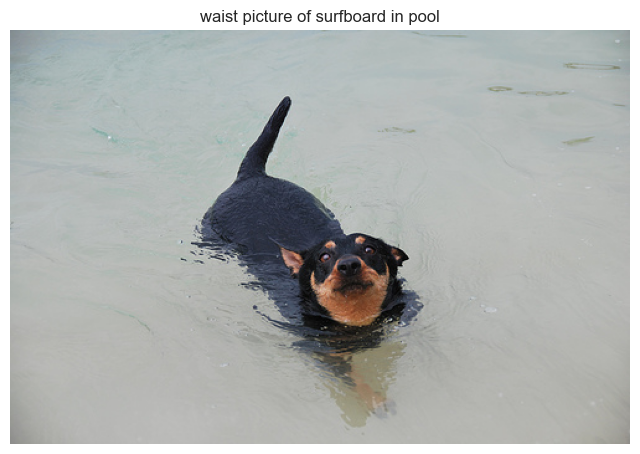

1/1 [==============================] - 0s 21ms/step


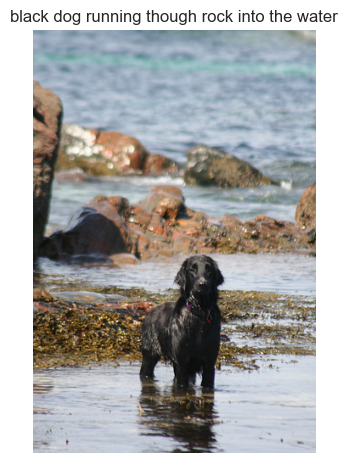

1/1 [==============================] - 0s 18ms/step


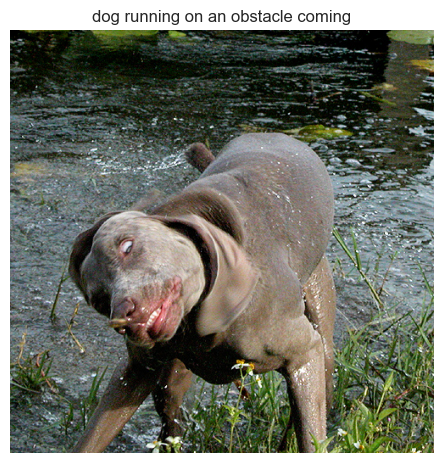

1/1 [==============================] - 0s 21ms/step


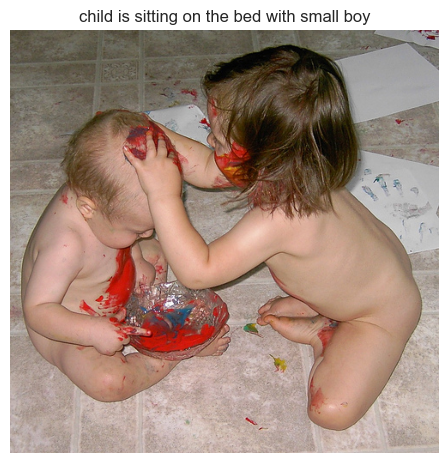

1/1 [==============================] - 0s 19ms/step


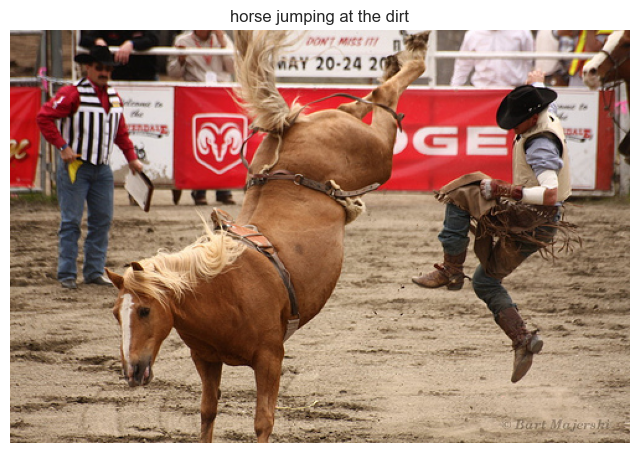

1/1 [==============================] - 0s 20ms/step


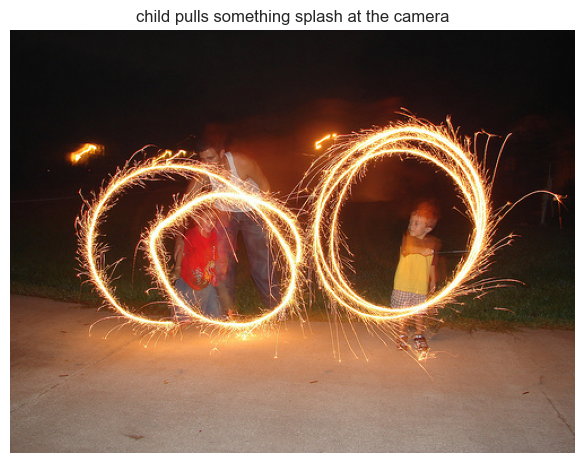

1/1 [==============================] - 0s 18ms/step


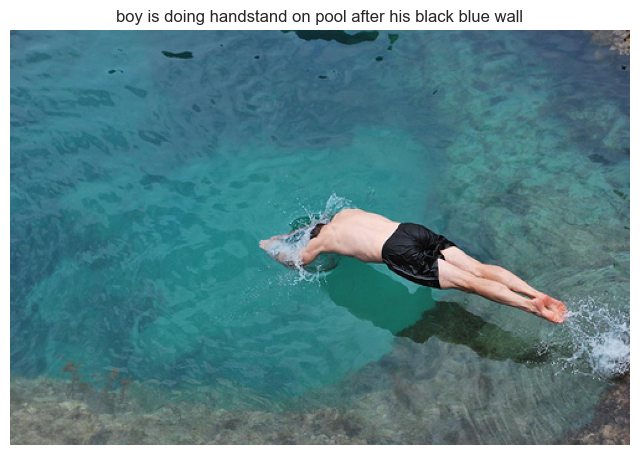

1/1 [==============================] - 0s 20ms/step


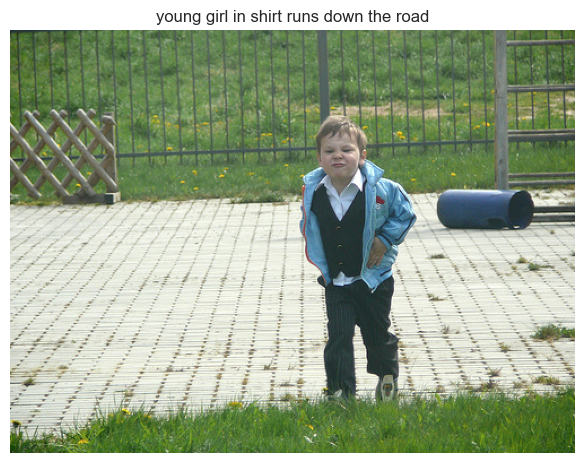

1/1 [==============================] - 0s 18ms/step


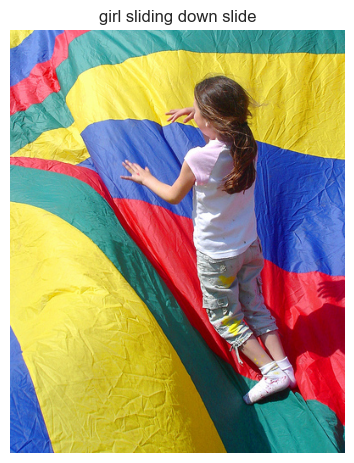

1/1 [==============================] - 0s 28ms/step


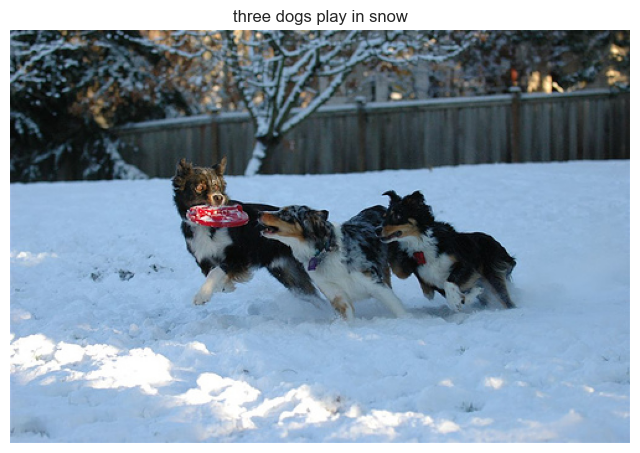

1/1 [==============================] - 0s 23ms/step


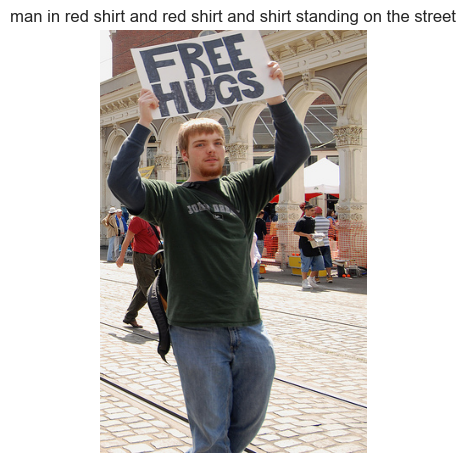

1/1 [==============================] - 0s 30ms/step


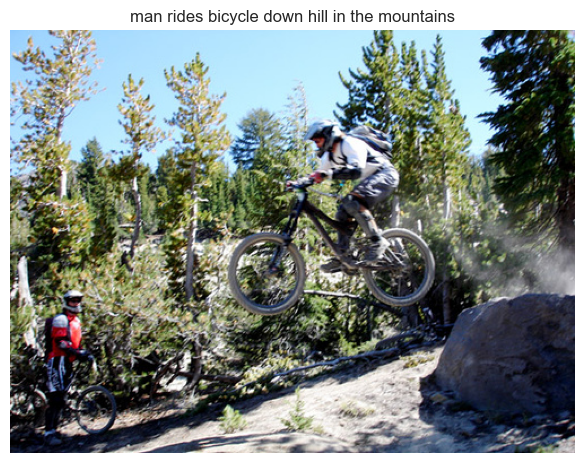

1/1 [==============================] - 0s 24ms/step


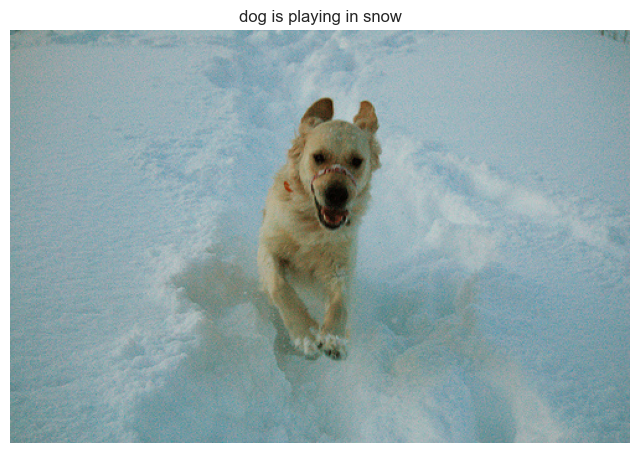

1/1 [==============================] - 0s 22ms/step


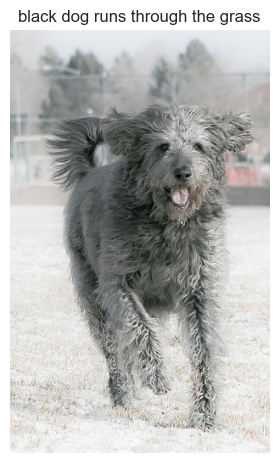

1/1 [==============================] - 0s 19ms/step


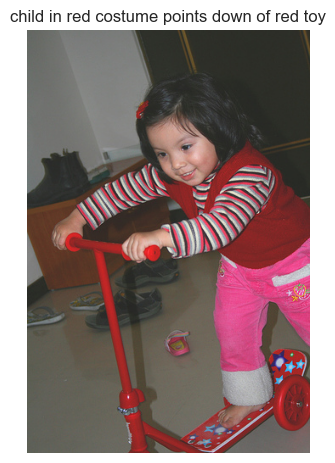

In [58]:
def predict_caption(img,model):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([img,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += (' ' +  word)
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("archive/Flickr8k_Dataset/Flicker8k_Dataset/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048,show_and_tell_model)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

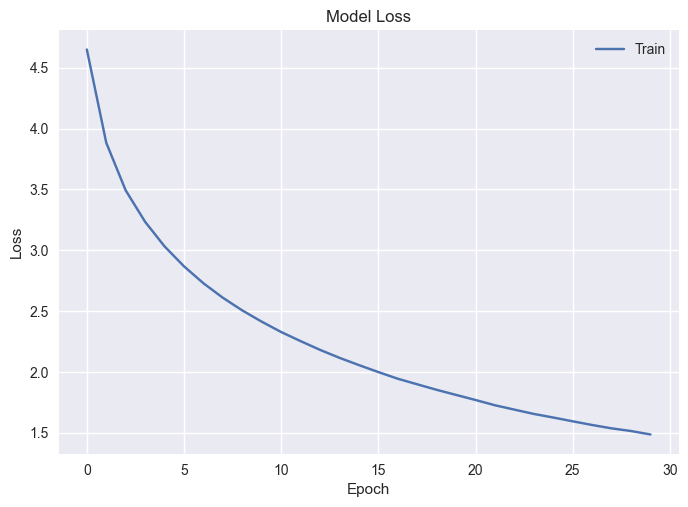

In [29]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()



In [55]:
with open("loss-30+10+15-epochs.pkl","wb") as f:
    pickle.dump(history_2.history,f)

In [56]:
with open("loss-30+10+15-epochs.pkl","rb") as f:
    loss30_10_15 = pickle.load(f)

In [57]:
loss30_10_15

{'loss': [1.2629750967025757,
  1.2483949661254883,
  1.231537103652954,
  1.2231587171554565,
  1.213123083114624,
  1.197391152381897,
  1.1818815469741821,
  1.1648629903793335,
  1.153144359588623,
  1.1450035572052002,
  1.1324011087417603,
  1.1378531455993652,
  1.1045658588409424,
  1.130907654762268,
  1.087279200553894]}

In [59]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
bleu1=[]
bleu2=[]
bleu3=[]
bleu4=[]
all_img_names = list(encoding_test.keys())

for i in range(1000):
    idx =i
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    caption = predict_caption(photo_2048,show_and_tell_model)
    bleu1.append(sentence_bleu([mapping_img_caption[img_name][0]], caption, weights=(1, 0, 0, 0)))
    bleu2.append(sentence_bleu([mapping_img_caption[img_name][0]], caption, weights=(0.5, 0.5, 0, 0)))
    bleu3.append(sentence_bleu([mapping_img_caption[img_name][0]], caption, weights=(0.33, 0.33, 0.33, 0)))
    bleu4.append(sentence_bleu([mapping_img_caption[img_name][0]], caption))
#     print(caption,'/n',descriptions[img_name][1])


1/1 [==============================] - 0s 63ms/step


/Users/josephkettaneh/miniforge3/envs/envTens/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/josephkettaneh/miniforge3/envs/envTens/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 18ms/step


/Users/josephkettaneh/miniforge3/envs/envTens/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


In [41]:
score1=np.mean(np.array(bleu1))
score2=np.mean(np.array(bleu2))
score3=np.mean(np.array(bleu3))
score4=np.mean(np.array(bleu4))
print("BLEU-1 score:", score1)
print("BLEU-2 score:", score2)
print("BLEU-3 score:", score3)
print("BLEU-4 score:", score4)

BLEU-1 score: 0.5138874435302985
BLEU-2 score: 0.36386094619337267
BLEU-3 score: 0.26514992344566946
BLEU-4 score: 0.20072030583611614


## 30 10 15

In [60]:
score1=np.mean(np.array(bleu1))
score2=np.mean(np.array(bleu2))
score3=np.mean(np.array(bleu3))
score4=np.mean(np.array(bleu4))
print("BLEU-1 score:", score1)
print("BLEU-2 score:", score2)
print("BLEU-3 score:", score3)
print("BLEU-4 score:", score4)

BLEU-1 score: 0.4973994351432077
BLEU-2 score: 0.3463231432368558
BLEU-3 score: 0.2457833703656798
BLEU-4 score: 0.1816236702365171
